In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import casadi as cas
plt.style.use('seaborn')

/var/folders/lh/93lccf9x56l539tw7z9d404r0000gn/T/ipykernel_39774/418906186.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [9]:
# Model
dt = 0.01
n = 4
X = cas.SX.sym('X', n)
Nu = cas.SX.sym('nu', 2)
U = cas.SX.sym('U', 2)

x = X[0]
y = X[1]
delta = X[2]
beta = X[3]

f = X + cas.vertcat(cas.cos(delta) * (U[0] + Nu[0]),
               cas.sin(delta) * (U[0] + Nu[0]),
               U[1] + Nu[1],
               0) * dt

h = cas.vertcat(x, # GPS
               0*y, # GPS
               - cas.sin(beta)*x + cas.cos(beta)*y,
               0*delta, # Magnetometer
               delta - beta # Cameras
               )

In [10]:
A = cas.jacobian(f, X)
G = cas.jacobian(f, Nu)
H = cas.jacobian(h, X)
A_fun = cas.Function('A_fun', [X, U, Nu], [A])
G_fun = cas.Function('G_fun', [X, U], [G])
H_fun = cas.Function('H_fun', [X], [H])
f_fun = cas.Function('F_fun', [X, U, Nu], [f])
h_fun = cas.Function('h_fun', [X], [h])

In [11]:
N = 10000

x0 = np.zeros(n)
x_hat = np.zeros((n, N))
x_true = np.zeros((n, N))

P = np.zeros((n, n, N))
P[:,:,0] = np.eye(n) * 1e-5
x_hat[:,0] = x0
x_true[:,0] = x0

u = np.array([1, 0.0])


sigma_eps_x = 1e-1
sigma_u = 1

Q = np.eye(2) * sigma_u**2
R = np.eye(5)*sigma_eps_x**2

nu = np.random.multivariate_normal([0, 0], Q, N).T
eps = np.random.multivariate_normal([0, 0, 0, 0, 0], R, N).T


for i in range(N-1):
    # Compute ground truth
    x_true[:,i+1] = f_fun(x_true[:,i], u, 0*nu[:,i]).full().flatten()

    if (np.random.rand() < 0.0):
        gps = 1
    else:
        gps = 0

    x = X[0]
    y = X[1]
    delta = X[2]
    beta = X[3]

    f = X + cas.vertcat(cas.cos(delta) * (U[0] + Nu[0]),
                cas.sin(delta) * (U[0] + Nu[0]),
                U[1] + Nu[1],
                0) * dt

    h = cas.vertcat(gps*x, # GPS
                gps*y, # GPS
                (- cas.sin(beta)*x + cas.cos(beta)*y),
                0*delta, # Magnetometer
                delta - beta # Cameras
                )
    
    A = cas.jacobian(f, X)
    G = cas.jacobian(f, Nu)
    H = cas.jacobian(h, X)
    A_fun = cas.Function('A_fun', [X, U, Nu], [A])
    G_fun = cas.Function('G_fun', [X, U], [G])
    H_fun = cas.Function('H_fun', [X], [H])
    f_fun = cas.Function('F_fun', [X, U, Nu], [f])
    h_fun = cas.Function('h_fun', [X], [h])

    A = A_fun(x_hat[:,i], u, 0*nu[:,i]).full()
    G = G_fun(x_hat[:,i], u).full()
    

    
    # Prediction step
    x_hat[:,i+1] = f_fun(x_hat[:,i], u, nu[:,i]).full().flatten()
    P[:,:, i+1] = A @ P[:,:,i] @ A.T + G @ Q @ G.T

    # Update step
    z = h_fun(x_true[:,i]).full().flatten() + eps[:,i]
    H = H_fun(x_hat[:,i]).full()

    s = H @ P[:,:,i+1] @ H.T + R
    w = P[:,:,i+1] @ H.T @ np.linalg.inv(s)
    x_hat[:,i+1] = x_hat[:,i+1] + (w @ (z.T - h_fun(x_hat[:,i+1]).full().flatten()))
    P[:,:,i+1] =  (np.eye(4) - w @ H) @ P[:,:,i+1]


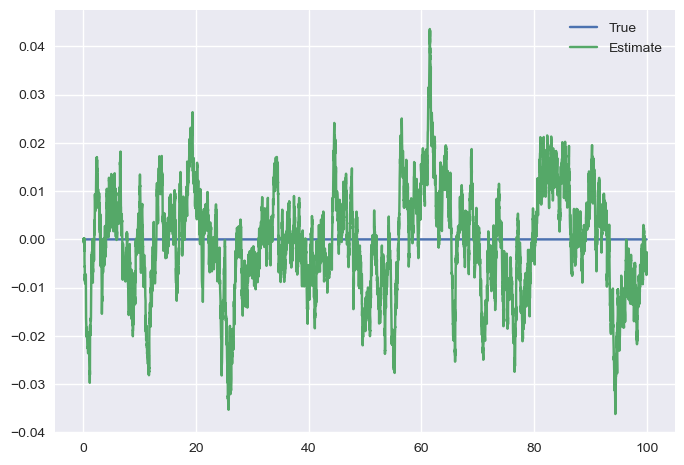

In [12]:
plt.plot(x_true[0,:], x_true[1,:])
plt.plot(x_hat[0,:], x_hat[1,:])
plt.legend(['True', 'Estimate'])

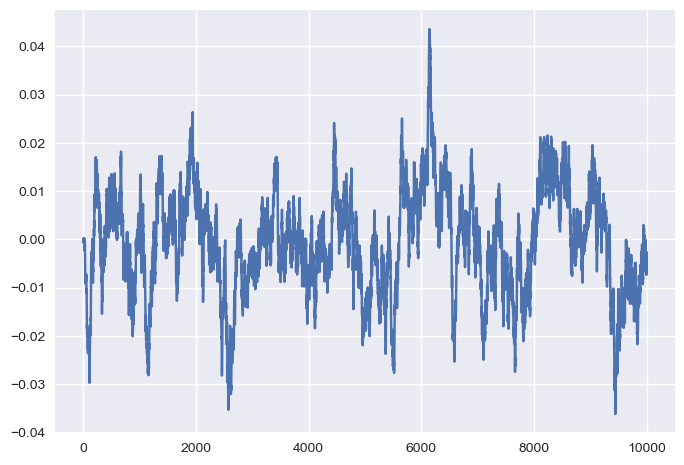

In [13]:
plt.plot(x_hat[1,:])

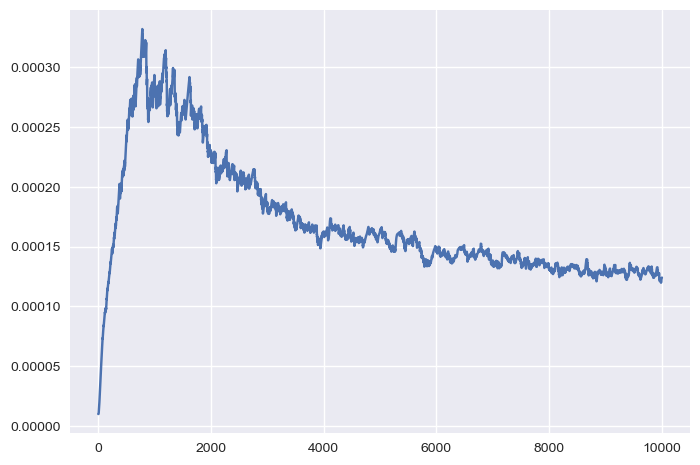

In [14]:
plt.plot(P[1,1,:])